### A Start at some correspondence analysis like I did for Corpus Linguistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import plotly.express as px
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text

2023-05-04 11:25:36.231641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 11:25:36.401615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-04 11:25:36.950606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-04 11:25:36.950706: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### [Skip to load previously saved contingency table](#loadctab)

In [3]:
tidy_oba = pd.read_csv('./Data/genData/tidy_data_oba.csv')
tidy_gwb = pd.read_csv('./Data/genData/tidy_data_gwb.csv')
tidy_oba = tidy_oba[['date','source']]
tidy_gwb = tidy_gwb[['date','source']]
tidy_both = pd.concat([tidy_oba, tidy_gwb])
tidy_both['date'] = pd.to_datetime(tidy_both['date'], format='%Y-%m-%d')

In [4]:
# Load the two data sets needed
# string encodings to try utf_8, iso8859_15
facetPlotData = pd.read_csv('./Data/genData/facetPlotData.csv')
df = pd.read_csv('./Data/genData/fullEmotionData.csv', encoding='utf_8') # apostrophes aren't being read correctly
# Pandas reads date as string, cast to datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
facetPlotData['date'] = pd.to_datetime(facetPlotData['date'], format='%Y-%m-%d')
facetPlotData.shape # Should be (3000, 4) 

(3000, 4)

<A HREF="https://regexr.com/">RegExr</A>

In [4]:
#Load SpaCy English Model
nlp = en_core_web_md.load()

In [5]:
punc = '''!()-[]{};:"\,<>./?—@#$%^&*_~â'''
sources = ['text_oba', 'text_nyt', 'text_wsj']
for source in sources:
    for i in range(len(df[source])):
        nopunc = ''.join([letter if letter not in punc else " " for letter in df[source][i] ])
        df.loc[i, source] =re.sub(' +', ' ', nopunc).replace('\n','').replace("' ", " ").strip()

In [6]:
# Function to find date of max emoValue for a particular source and emotion
def findmax(sourcefm, emofm, printyn):
    '''
    Function to print date of maximum value of subset of data
    # sourcefm - source name (oba, nyt, wsj)
    # emofm - emotion name (fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation)
    # printyn = 0 or 1 to print text
    '''
    find = facetPlotData[(facetPlotData['source'] == sourcefm) & (facetPlotData['emotion'] == emofm)]
    result = find.loc[find['emoValue'].idxmax()]
    date = result['date'].strftime('%Y-%m-%d')
    print(date, round(result['emoValue'], 4))
    if printyn == 1:
        text = 'text_' + sourcefm
        print(df.query('date == @date')[text])

In [7]:
findmax('oba', 'positive', 1)

2014-03-07 0.4107
65    Good afternoon everybody Before Jay takes some...
Name: text_oba, dtype: object


### <A HREF="https://www.nltk.org/index.html">NLTK Documentation</A> <A HREF="https://www.tomaarsen.com/nltk/api/nltk.html">API reference</A>

<a id='loadctab'>Load Contingency Table</a>

In [8]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab_oba = pd.read_csv('./Data/genData/obamaContingencyTable_noSW_150.csv',index_col=0)
ctab_gwb = pd.read_csv('./Data/genData/GWB_ContingencyTable_noSW_150.csv', index_col=0)
# Shorten row index names to date only
ctab_oba = ctab_oba.rename(index = lambda x: x[0:10])
ctab_gwb = ctab_gwb.rename(index = lambda x: x[0:10])

In [9]:
# Let's look at the 150 most common words
ctabshort_oba=ctab_oba.iloc[:, : 150].copy(deep=True)
ctabshort_gwb=ctab_gwb.iloc[:, : 150].copy(deep=True)

In [10]:
ctab_oba = None
ctab_gwb = None

<A HREF="https://github.com/MaxHalford/prince#correspondence-analysis-ca">Prince Correspondence Analysis</A>

In [11]:
cao = prince.CA(n_components=2,
               n_iter=10,
               copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)
cag = prince.CA(n_components=2,
               n_iter=10,
               copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)

In [12]:
ctabshort_oba.columns.rename('words', inplace=True)
ctabshort_gwb.columns.rename('words', inplace=True)
ctabshort_oba.index.rename('speeches', inplace=True)
ctabshort_gwb.index.rename('speeches', inplace=True)
ca_oba = cao.fit(ctabshort_oba)
ca_gwb = cag.fit(ctabshort_gwb)

In [13]:
ca_oba.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.144,10.74%,10.74%
1,0.090,6.72%,17.46%


<A HREF="https://maxhalford.github.io/prince/ca/">Prince correspondence analysis</A>

In [14]:
cao.plot(
    ctabshort_oba,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [15]:
cag.plot(
    ctabshort_gwb,
    x_component=0,
    y_component=1
)

alt.Chart(...)

<A HREF="https://matplotlib.org/cheatsheets/cheatsheets.pdf">Matplotlib basic cheat sheet</A><BR>
    <A HREF="https://matplotlib.org/cheatsheets/">other matplotlib cheat sheets</A>

From NRC analysis the speech with particularly high anger value was 2015-01-08
and particularly high positive value on 2014-03-07

/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/muddy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


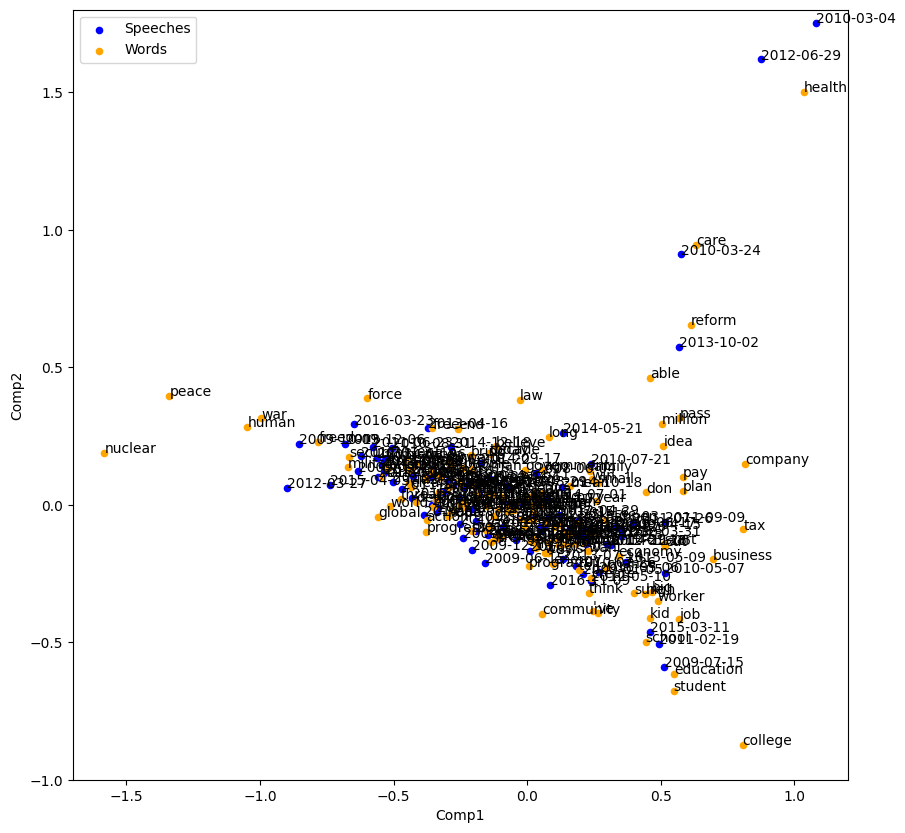

In [16]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=cao.row_coordinates(ctabshort_oba)
df1.columns=['Comp1', 'Comp2']
df2=cao.column_coordinates(ctabshort_oba)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 1.8])
plt.legend(['Speeches', 'Words'])
plt.show()

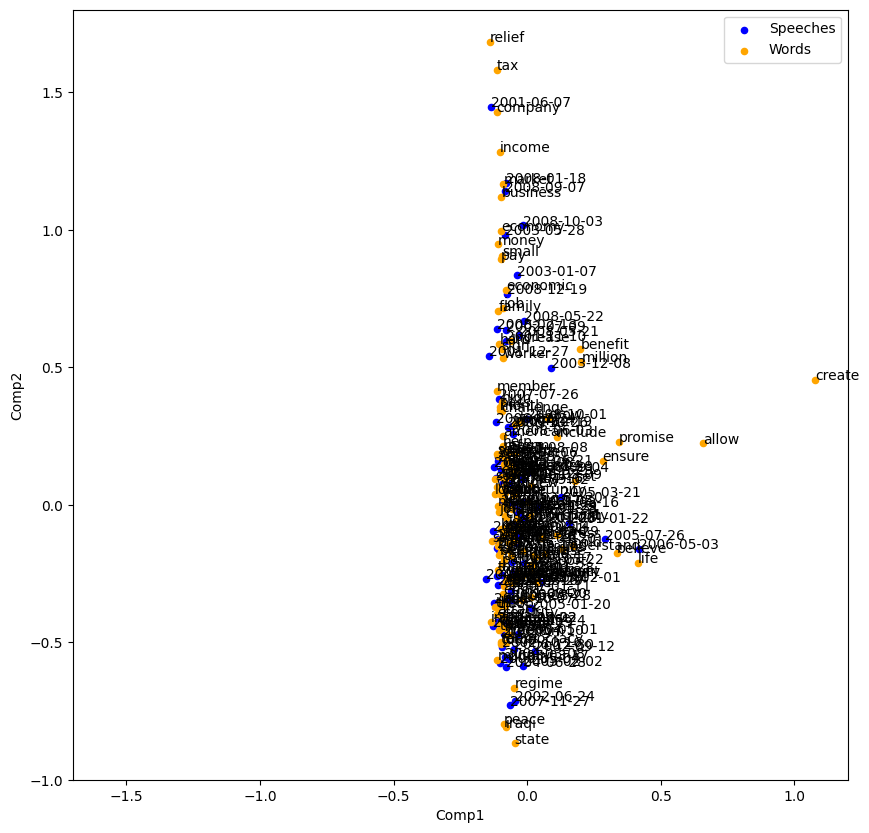

In [17]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=cag.row_coordinates(ctabshort_gwb)
df1.columns=['Comp1', 'Comp2']
df2=cag.column_coordinates(ctabshort_gwb)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-1.7, 1.2])
plt.ylim([-1.0, 1.8])
plt.legend(['Speeches', 'Words'])
plt.show()

In [18]:
'''
date1 = '2015-01-08' # date 1 is red X
date2 = '2011-05-02' # date 2 is green pentagon
df1=ca.row_coordinates(ctabshort3)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort3)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches - blue
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words - orange
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-0.9, -0.4])
plt.ylim([0.1, 0.4])
plt.show()
'''

"\ndate1 = '2015-01-08' # date 1 is red X\ndate2 = '2011-05-02' # date 2 is green pentagon\ndf1=ca.row_coordinates(ctabshort3)\ndf1.columns=['Comp1', 'Comp2']\ndf2=ca.column_coordinates(ctabshort3)\ndf2.columns=['Comp1', 'Comp2']\n\n# df1 for speeches - blue\nax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')\nfor i, txt in enumerate(df1.index.values.tolist()):\n    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))\n\n# df2 for words - orange\ndf2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')\nfor i, txt in enumerate(df2.index.values.tolist()):\n    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))\n\nax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)\nax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)\n\nplt.xlim([-0.9, -0.4])\nplt.ylim([0.1, 0.4])\nplt.show()\n"

### Look at both Obama and Bush together

<A HREF="https://maxhalford.github.io/prince/ca/">Prince CA</A> doesn't play nice with pandas multiindex

In [5]:
ctab_both = pd.read_csv('./Data/genData/ContingencyTable_noSW_both.csv',index_col=0)
ctab_both['date'] = ctab_both.index
ctab_both['date'] = pd.to_datetime(ctab_both['date'], format='%Y-%m-%d')
ctab_both.index.names = ['dateidx']
ctab_both = pd.merge(ctab_both, tidy_both, how='inner', on='date')
ctab_both = ctab_both.rename(columns={'source_y': 'source'})
ctab_both.set_index(['date'], inplace=True)

In [6]:
ctabshort_both=ctab_both.iloc[:, : 200].copy(deep=True)
cab = prince.CA(n_components=2,
               n_iter=10,
               copy=True,
               check_input=True,
               engine='sklearn',
               random_state=33)
ctabshort_both.columns.rename('words', inplace=True)
ctabshort_both.index.rename('date',inplace=True)
cab = cab.fit(ctabshort_both)
cab.plot(
    ctabshort_both,
    x_component=0,
    y_component=1
)

alt.Chart(...)

In [7]:
speeches = cab.row_coordinates(ctabshort_both)
speeches['date']=speeches.index
speeches.index.names = ['dateidx']
speeches = pd.merge(speeches, tidy_both, how='left', on='date')
speeches['date'] = pd.to_datetime(speeches['date'], format='%Y-%m-%d')
speeches['colors'] = speeches['source'].apply(lambda x: 0 if x=='gwb' else 1)

In [13]:
words = cab.column_coordinates(ctabshort_both)
words['word'] = words.index

In [77]:
speeches_gwb = speeches.query('source == "gwb"')
speeches_oba = speeches.query('source == "oba"')

In [1]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=words.iloc[::,0], y=words.iloc[::,1],
    name='words',
    marker=dict(color='#00CC96'),
    marker_size=8,
    text=words.index,
    textposition=['top center'],
    showlegend=True,
    legendgroup=True
))

fig.add_trace(go.Scatter(
    x=speeches_oba.iloc[::,0], y=speeches_oba.iloc[::,1],
    name='Obama',
    mode='markers',
    marker=dict(color='#636EFA'),
    #text = speeches_oba.source,
    marker_size=12,
    showlegend=True,
    legendgroup=True
))

fig.add_trace(go.Scatter(
    x=speeches_gwb.iloc[::,0], y=speeches_gwb.iloc[::,1],
    name='Bush',
    mode='markers',
    marker=dict(color='#EF553B'),
    #text = speeches_gwb.source,
    marker_size=12,
    showlegend=True,
    legendgroup=True
))

fig.update_traces(mode='markers+text', marker_line_width=1)
fig.update_layout(title='Correspondence Analysis: Words vs Speeches',
                  yaxis_zeroline=True, xaxis_zeroline=True)
fig.update_traces(textposition="top center")
fig.update_layout(height=600)
fig.update_layout(showlegend=True)
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

NameError: name 'go' is not defined

In [100]:
fig.write_image("./plots/ca_biplot_obama_bush.png", format='png', engine='kaleido')

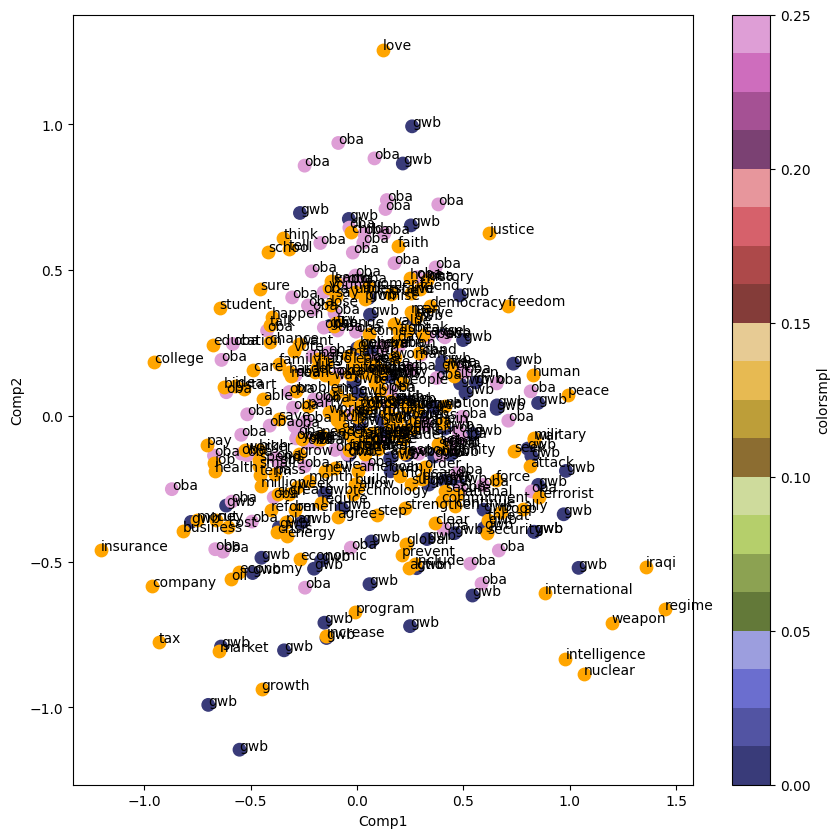

In [10]:
df1=None
df1=speeches
#df1.columns=['Comp1', 'Comp2', 'date', 'source', 'colors','colorsmpl']
df1.columns=['Comp1', 'Comp2', 'date', 'source', 'colors']
df1.index=df1.source
df1['colorsmpl'] = df1.colors*0.25
df2=words
df2.columns=['Comp1', 'Comp2', 'word']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', c='colorsmpl', s=80,
              figsize=(10, 10), kind='scatter', cmap='tab20b')

for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='Orange', s=80)

for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

plt.show()